Simple exploratory analysis.
Dropping cabin information and removing individuals with no age.

**Dimension reduction is vaguely interesting**

**I have issues with plotting graphviz files**

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import preprocessing
import tensorflow as tf

In [3]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

genderclassmodel.csv
gendermodel.csv
gendermodel.py
myfirstforest.py
test.csv
train.csv



## Basic exploratory analysis ##

In [4]:
train_data = pd.read_csv('../input/train.csv', dtype={'Age': np.float16})
test_data = pd.read_csv('../input/test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print('train size: %d, test size: %d' % (train_data.size, test_data.size))

train size: 10692, test size: 4598


In [6]:
**Check incomplete information**

SyntaxError: invalid syntax (<ipython-input-6-27ed6119bf65>, line 1)

In [7]:
nans = {}
for colname in train_data.columns:
    nans[colname] = train_data[train_data[colname].isnull()].size
nans

{'Age': 2124,
 'Cabin': 8244,
 'Embarked': 24,
 'Fare': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

See if passengers with not Age and Cabin info had some common feature (betting class=3  for most)

**Drop cabin and lack of age segregation**

In [8]:
old_train_data = train_data.copy()
try:
    train_data.drop('Cabin', 1, inplace=True)
except ValueError:
    pass  # Probably repeating cell execution
train_data = train_data[train_data['Age'].notnull()]
train_data.size

7854

**Helicopter view**
Pie charts are evil... well, maybe sometimes not

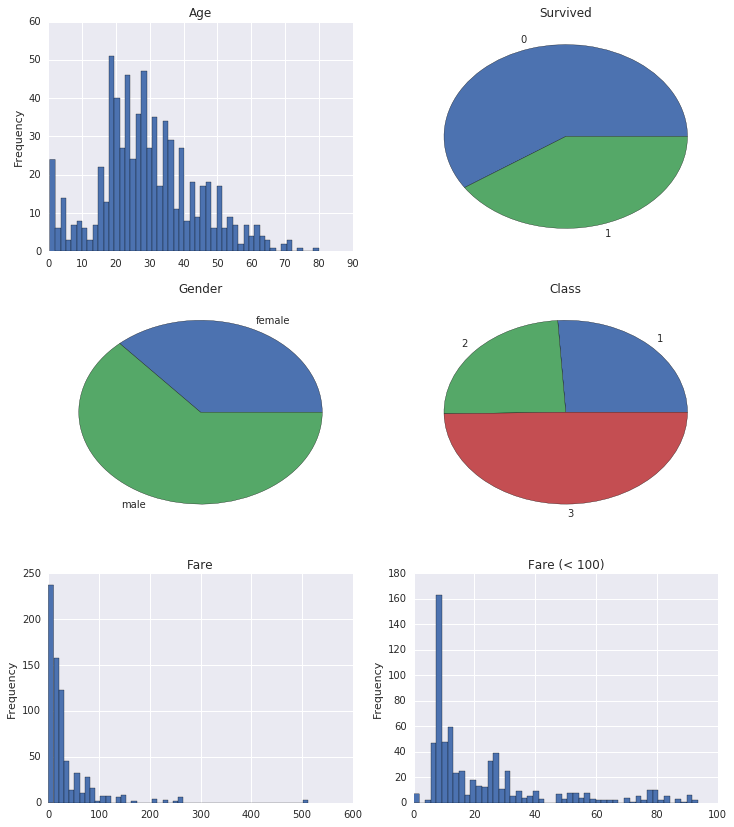

In [9]:
fig, axs = plt.subplots(3, 2, squeeze=False, figsize=(12, 14))
train_data.Age.plot.hist(bins=50, title='Age', ax=axs[0, 0])
train_data.groupby('Survived').agg('count')['Age'].plot.pie(title='Survived', ax=axs[0, 1])
axs[0, 1].set_ylabel('')
train_data.groupby('Sex').agg('count')['Age'].plot.pie(title='Gender', ax=axs[1, 0])
axs[1, 0].set_ylabel('')
train_data.groupby('Pclass').agg('count')['Age'].plot.pie(title='Class', ax=axs[1, 1])
axs[1, 1].set_ylabel('')
fare = train_data.Fare
fare.plot.hist(bins=50, title='Fare', ax=axs[2, 0])
fare[fare < 100].plot.hist(bins=50, title='Fare (< 100)', ax=axs[2, 1])

**Survivalship by feature** Helicopter view (using KDE)

In [10]:
train_survive = train_data[train_data.Survived == 1]
train_dead = train_data[train_data.Survived == 0]

In [11]:
def plot_kde(fig, ncols, nrows, mypos, title, feature, xmin=0, xmax=None):
    ax = fig.add_subplot(ncols, nrows, mypos)
    train_survive[feature].plot.kde(ax=ax, color='g')
    train_dead[feature].plot.kde(ax=ax, color='r')
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)

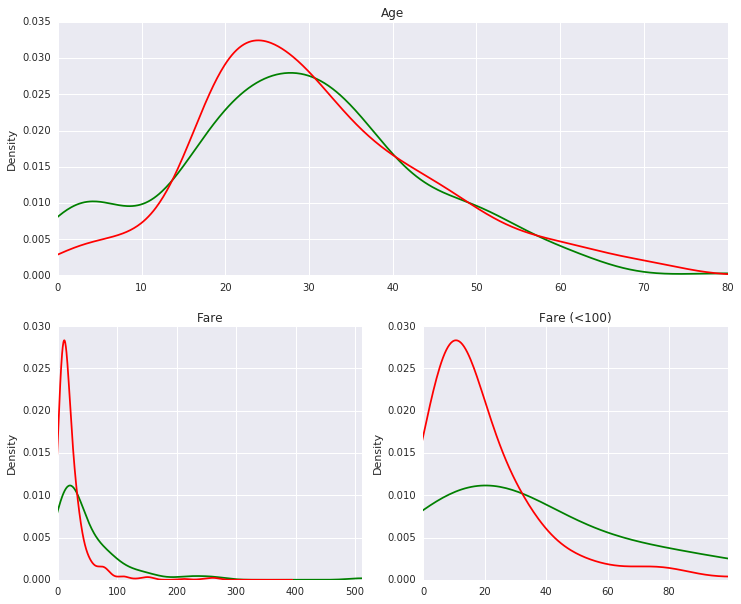

In [12]:
fig = plt.figure(figsize=(12, 10))

plot_kde(fig, 2, 1, 1, 'Age', 'Age', xmax=train_data.Age.max())
plot_kde(fig, 2, 2, 3, 'Fare', 'Fare', xmax=train_data.Fare.max())
plot_kde(fig, 2, 2, 4, 'Fare (<100)', 'Fare', xmax=99)

#We will define from plot 1, child as < 15.

New feature definition: **child**

In [13]:
train_data['Child'] = train_data.apply(lambda row: 1 if row['Age'] < 15 else 0, axis=1)
test_data['Child'] = test_data.apply(lambda row: 1 if row['Age'] < 15 else 0, axis=1)

**Survaivalship by feature**

In [14]:
sex_group = train_data[['Sex', 'Survived']].groupby('Sex')

In [15]:
sex_agg = sex_group.agg(['sum', 'count'])['Survived']
sex_agg['rate'] = sex_agg.apply(lambda row: row['sum'] / row['count'], axis=1)
sex_agg

,sum,count,rate
Sex,,,
female,197,261,0.754789
male,93,453,0.205298


In [16]:
class_group = train_data[['Pclass', 'Survived']].groupby('Pclass')

In [17]:
class_agg = class_group.agg(['sum', 'count'])['Survived']
class_agg['rate'] = class_agg.apply(lambda row: row['sum'] / row['count'], axis=1)
class_agg

,sum,count,rate
Pclass,,,
1,122,186,0.655914
2,83,173,0.479769
3,85,355,0.239437


In [18]:
train_data.groupby(['Child', 'Survived']).size()

Child  Survived
0      0           391
       1           245
1      0            33
       1            45
dtype: int64

In [19]:
train_data[train_data['Child'] == 1].groupby(['Pclass', 'Sex', 'Survived']).size()

Pclass  Sex     Survived
1       female  0            1
                1            1
        male    1            3
2       female  1           10
        male    1            9
3       female  0           14
                1           13
        male    0           18
                1            9
dtype: int64

In [20]:
train_data.groupby(['Pclass', 'Sex', 'Survived']).size()

Pclass  Sex     Survived
1       female  0             3
                1            82
        male    0            61
                1            40
2       female  0             6
                1            68
        male    0            84
                1            15
3       female  0            55
                1            47
        male    0           215
                1            38
dtype: int64

In [21]:
#Fare price by gender
#Fare price for children
#survivalship with adults

# ML Methods as exploratory analysis

We will be using a few features, including the child one

In [22]:
train_features = ['Age', 'Fare', 'Sex_number', 'Pclass', 'Child']
train_data['Sex_number'] = train_data.apply(lambda row: 0 if row['Sex'] == 'male' else 1, axis=1)
train_X = train_data[train_features].as_matrix()
train_Y = train_data.Survived.as_matrix()
train_data[train_features].head()

,Age,Fare,Sex_number,Pclass,Child
0,22.0,7.2500,0,3,0
1,38.0,71.2833,1,1,0
2,26.0,7.9250,1,3,0
3,35.0,53.1000,1,1,0
4,35.0,8.0500,0,3,0


In [23]:
tree_clf = tree.DecisionTreeClassifier()
my_tree = tree_clf.fit(train_X, train_Y)
with open('tree.dot', 'w') as w:
    tree.export_graphviz(my_tree, out_file=w, max_depth=4,
                         feature_names=train_features, filled=True)

#with open('tree.dot') as f:
#    print(''.join(f.readlines()))

**No way to print a dot file?**

## Principal Components Analysis

In [24]:
my_pca = PCA(n_components=2)
preprocessed_train = preprocessing.normalize(preprocessing.scale(train_X))
print(preprocessed_train.shape)
#missing feature scaling and normalization
my_pca.fit(preprocessed_train)
trans = my_pca.transform(preprocessed_train)

(714, 5)


In [25]:
**Results below**: The coloring is given from existing features

SyntaxError: invalid syntax (<ipython-input-25-7c4bef47b704>, line 1)

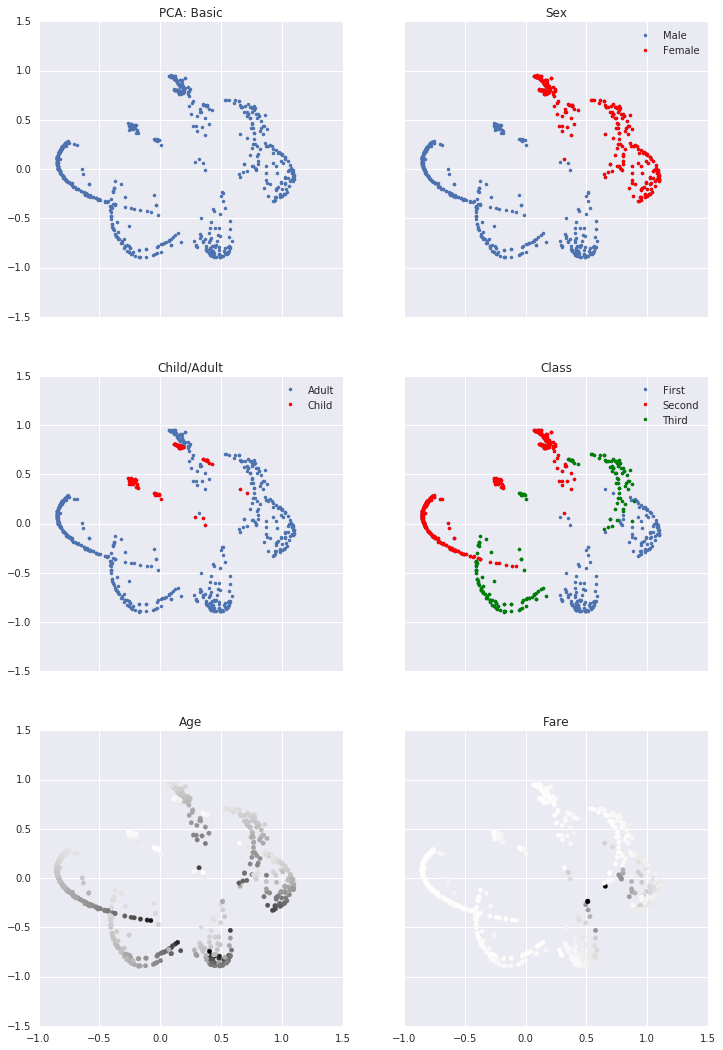

In [26]:
fig, axs = plt.subplots(3, 2, squeeze=False, sharex=True, sharey=True, figsize=(12, 18))
axs[0, 0].plot(trans[:,0], trans[:,1], '.')
axs[0, 0].set_title('PCA: Basic')

female_trans = np.array([tran for is_female, tran in zip(train_data['Sex_number'], trans) if is_female==1])
axs[0, 1].plot(trans[:,0], trans[:,1], '.', label='Male')
axs[0, 1].plot(female_trans[:,0], female_trans[:,1], 'r.', label='Female')
axs[0, 1].set_title('Sex')
axs[0, 1].legend()

child_trans = np.array([tran for is_child, tran in zip(train_data['Child'], trans) if is_child==1])
axs[1, 0].plot(trans[:,0], trans[:,1], '.', label='Adult')
axs[1, 0].plot(child_trans[:,0], child_trans[:,1], 'r.', label='Child')
axs[1, 0].set_title('Child/Adult')
axs[1, 0].legend()

third_trans = np.array([tran for my_class, tran in zip(train_data['Pclass'], trans) if my_class==3])
second_trans = np.array([tran for my_class, tran in zip(train_data['Pclass'], trans) if my_class==2])
axs[1, 1].plot(trans[:,0], trans[:,1], '.', label='First')
axs[1, 1].plot(third_trans[:,0], third_trans[:,1], '.r', label='Second')
axs[1, 1].plot(second_trans[:,0], second_trans[:,1], '.g', label='Third')
axs[1, 1].set_title('Class')
axs[1, 1].legend()

axs[2, 0].scatter(trans[:,0], trans[:,1], edgecolors='face', c=train_data['Age'].as_matrix())
axs[2, 0].set_title('Age')

axs[2, 1].scatter(trans[:,0], trans[:,1], edgecolors='face', c=train_data['Fare'].as_matrix())
axs[2, 1].set_title('Fare')

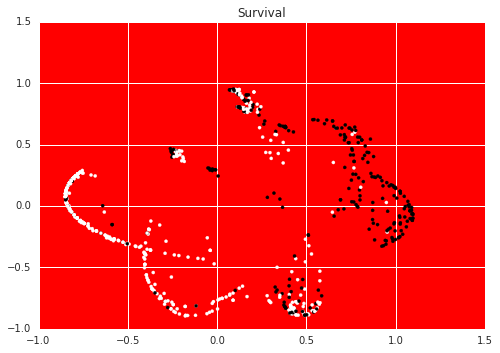

In [27]:
fig, ax = plt.subplots()
ax.set_axis_bgcolor('red')
ax.scatter(trans[:,0], trans[:,1], edgecolors='face', s=10, c=train_data['Survived'].as_matrix())
ax.set_title('Survival')

In [28]:
**Ad-hoc conclusion** Dimensionality reduction actually segregates survivability quite a lot

SyntaxError: invalid syntax (<ipython-input-28-60debddf0e72>, line 1)

# Appendix: No age

Caveat: obviously rows with no age cannot be excluded as they have different properties. But for a start we will have it out.

In [29]:

no_age = old_train_data[old_train_data['Age'].isnull()]

In [30]:
print(no_age.groupby(['Survived']).size())
print(train_data.groupby(['Survived']).size())

Survived
0    125
1     52
dtype: int64
Survived
0    424
1    290
dtype: int64


In [31]:
print(no_age.groupby(['Pclass']).size())
print(train_data.groupby(['Pclass']).size())

Pclass
1     30
2     11
3    136
dtype: int64
Pclass
1    186
2    173
3    355
dtype: int64


In [32]:
print(no_age.groupby(['Sex']).size())
print(train_data.groupby(['Sex']).size())

Sex
female     53
male      124
dtype: int64
Sex
female    261
male      453
dtype: int64
